In [1]:
import copy
import glob
import pickle
import warnings
from datetime import datetime, timedelta
from itertools import product
import joblib
import os

import cartopy
import cartopy.crs as ccrs
import cartopy.feature
import cartopy.feature as cfeature
import cartopy.feature as cf
import cartopy.io.shapereader as shpreader
import matplotlib as mpl
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import numpy as np
# np.random.seed(42)
import pandas as pd
import shapely.geometry as sgeom
import xarray as xr
from scipy import stats
from scipy.spatial.distance import cdist
from shapely import geometry
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


In [2]:
folder_results_week3 = '/glade/work/jhayron/Data4Predictability/models/CNN/results_optuna/week3/'
files_results = glob.glob(f'{folder_results_week3}*.csv')

In [3]:
dic_results = {}
name_vars = []
for i in range(len(files_results)):
    name_var = files_results[i].split('df_optuna_results_')[-1][:-7].split('_')[0]
    df_results = pd.read_csv(files_results[i],index_col = 1)
    print(name_var, f' - Number of completed trials: {len(df_results)}')
    name_vars.append(name_var)
    dic_results[name_var] = df_results
    
name_vars = np.array(name_vars)

U10  - Number of completed trials: 333
IT  - Number of completed trials: 18
OLR  - Number of completed trials: 198
SWVL  - Number of completed trials: 271
OHC100  - Number of completed trials: 243
Z500  - Number of completed trials: 2
SD  - Number of completed trials: 33
SST  - Number of completed trials: 297


In [4]:
test_accuracies_mean = []
val_accuracies_mean = []
test_bal_accuracies_mean = []
val_bal_accuracies_mean = []

test_accuracies_max = []
val_accuracies_max = []
test_bal_accuracies_max = []
val_bal_accuracies_max = []

test_accuracies_std = []
val_accuracies_std = []
test_bal_accuracies_std = []
val_bal_accuracies_std = []

n_trials = []

In [5]:
for i in range(len(name_vars)):
    test_accuracies_mean.append(dic_results[name_vars[i]]['user_attrs_test_accuracy'].mean())
    val_accuracies_mean.append(dic_results[name_vars[i]]['user_attrs_val_accuracy'].mean())
    test_bal_accuracies_mean.append(dic_results[name_vars[i]]['user_attrs_test_balanced_accuracy'].mean())
    val_bal_accuracies_mean.append(dic_results[name_vars[i]]['user_attrs_val_balanced_accuracy'].mean())
    
    test_accuracies_std.append(dic_results[name_vars[i]]['user_attrs_test_accuracy'].std())
    val_accuracies_std.append(dic_results[name_vars[i]]['user_attrs_val_accuracy'].std())
    test_bal_accuracies_std.append(dic_results[name_vars[i]]['user_attrs_test_balanced_accuracy'].std())
    val_bal_accuracies_std.append(dic_results[name_vars[i]]['user_attrs_val_balanced_accuracy'].std())
    
    test_accuracies_max.append(dic_results[name_vars[i]]['user_attrs_test_accuracy'].max())
    val_accuracies_max.append(dic_results[name_vars[i]]['user_attrs_val_accuracy'].max())
    test_bal_accuracies_max.append(dic_results[name_vars[i]]['user_attrs_test_balanced_accuracy'].max())
    val_bal_accuracies_max.append(dic_results[name_vars[i]]['user_attrs_val_balanced_accuracy'].max())
    
    n_trials.append(len(dic_results[name_vars[i]]))

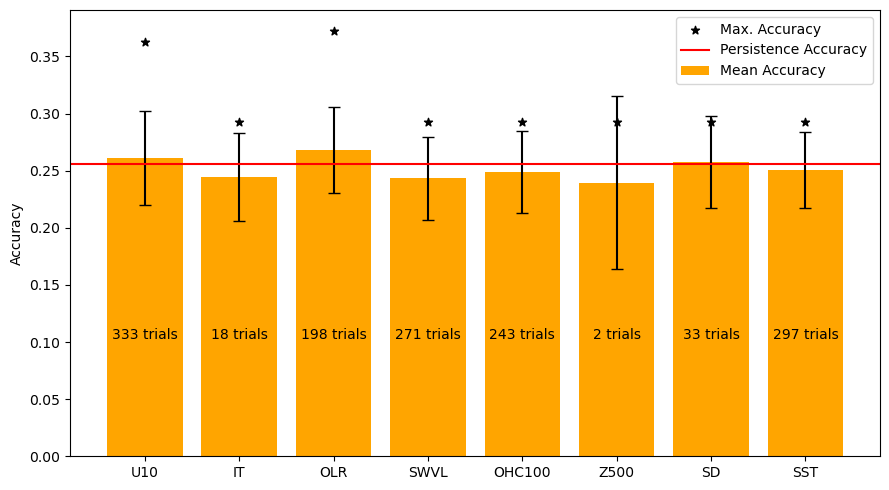

In [18]:
# Create a bar plot
fig, ax = plt.subplots(figsize=(9,5))
bars = ax.bar(name_vars, test_accuracies_mean, yerr=test_accuracies_std, capsize=4,color='orange',label = 'Mean Accuracy')
plt.scatter(name_vars,test_accuracies_max,marker='*',color='k',label = 'Max. Accuracy')
plt.axhline(metrics.accuracy_score(df_shifts[['week0','week3']].dropna().week0,df_shifts[['week0','week3']].dropna().week3),
            color='red',
            label = 'Persistence Accuracy')

# Add labels and title
ax.set_ylabel('Accuracy')
# ax.set_title('Mean Error with Standard Deviation')

# Add text above each bar showing the mean and standard deviation
for bar,n in zip(bars, n_trials):
    # ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
    #         f'{n} trials', ha='center', va='bottom')
    ax.text(bar.get_x() + bar.get_width() / 2, 0.1,
            f'{n} trials', ha='center', va='bottom')
    # ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.2,
    #         f'$\pm$ {std_error:.2f}', ha='center', va='bottom', fontsize=10)
plt.legend()

plt.tight_layout()
plt.show()

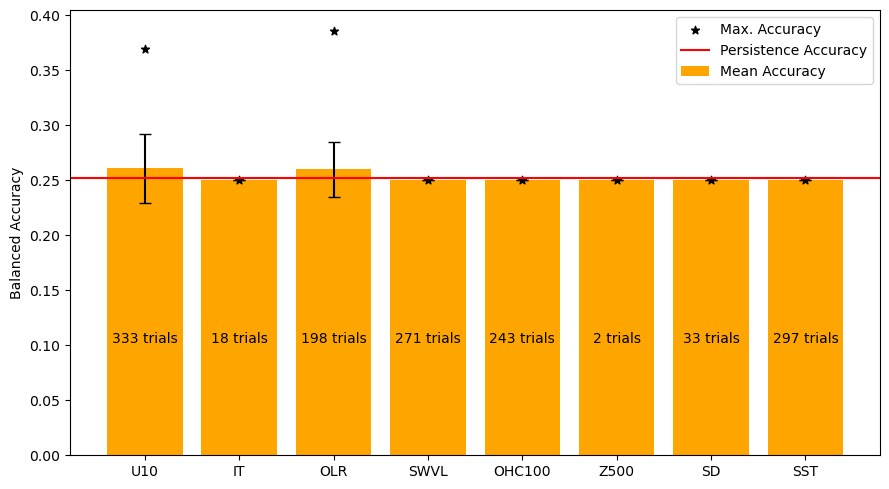

In [19]:
# Create a bar plot
fig, ax = plt.subplots(figsize=(9,5))
bars = ax.bar(name_vars, test_bal_accuracies_mean, yerr=test_bal_accuracies_std, capsize=4,color='orange',label = 'Mean Accuracy')
plt.scatter(name_vars,test_bal_accuracies_max,marker='*',color='k',label = 'Max. Accuracy')
plt.axhline(metrics.balanced_accuracy_score(df_shifts[['week0','week3']].dropna().week0,df_shifts[['week0','week3']].dropna().week3),
            color='red',
            label = 'Persistence Accuracy')
# Add labels and title
ax.set_ylabel('Balanced Accuracy')
# ax.set_title('Mean Error with Standard Deviation')

# Add text above each bar showing the mean and standard deviation
for bar,n in zip(bars, n_trials):
    # ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
    #         f'{n} trials', ha='center', va='bottom')
    ax.text(bar.get_x() + bar.get_width() / 2, 0.1,
            f'{n} trials', ha='center', va='bottom')
    # ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.2,
    #         f'$\pm$ {std_error:.2f}', ha='center', va='bottom', fontsize=10)
plt.legend()

plt.tight_layout()
plt.show()

In [8]:
wr_series = pd.read_csv('/glade/work/jhayron/Data4Predictability/WR_Series.csv',\
                index_col=0,names=['week0'],skiprows=1,parse_dates=True)
for wk in range(2,10):
    series_temp = copy.deepcopy(wr_series["week0"])
    series_temp.index = series_temp.index - timedelta(weeks = wk-1)
    series_temp.name = f'week{wk-1}'
    if wk==2:
        df_shifts = pd.concat([pd.DataFrame(wr_series["week0"]),pd.DataFrame(series_temp)],axis=1)  
    else:
        df_shifts = pd.concat([df_shifts,pd.DataFrame(series_temp)],axis=1)

# Group parameters

In [36]:
for typemodel in np.unique(dic_results['OLR']['params_model_base']):
    print('******-'+typemodel+'-******')
    print(f'Length: '+ str(len(dic_results['OLR'][dic_results['OLR']['params_model_base'] == typemodel])))
    print('Max accuracy: ', dic_results['OLR'][dic_results['OLR']['params_model_base'] == typemodel].user_attrs_test_accuracy.max())
    print('Max balanced accuracy: ', dic_results['OLR'][dic_results['OLR']['params_model_base'] == typemodel].user_attrs_test_balanced_accuracy.max())
    print('Mean accuracy: ', dic_results['OLR'][dic_results['OLR']['params_model_base'] == typemodel].user_attrs_test_accuracy.mean())
    print('Mean balanced accuracy: ', dic_results['OLR'][dic_results['OLR']['params_model_base'] == typemodel].user_attrs_test_balanced_accuracy.mean())
    dic_results['OLR'][dic_results['OLR']['params_model_base'] == typemodel]

******-densenet-******
Length: 66
Max accuracy:  0.3720930218696594
Max balanced accuracy:  0.3853026926517486
Mean accuracy:  0.2838618755340576
Mean balanced accuracy:  0.2714069851420142
******-inception-******
Length: 35
Max accuracy:  0.2976744174957275
Max balanced accuracy:  0.2890344262123108
Mean accuracy:  0.2518272455249514
Mean balanced accuracy:  0.25260716676712036
******-resnet101-******
Length: 9
Max accuracy:  0.302325576543808
Max balanced accuracy:  0.3094700276851654
Mean accuracy:  0.24702842699156868
Mean balanced accuracy:  0.2557020088036855
******-resnet50-******
Length: 63
Max accuracy:  0.3255814015865326
Max balanced accuracy:  0.2976481318473816
Mean accuracy:  0.26511628168915946
Mean balanced accuracy:  0.2558141629847269
******-vanilla-******
Length: 16
Max accuracy:  0.330232560634613
Max balanced accuracy:  0.3029272556304931
Mean accuracy:  0.27005814108997583
Mean balanced accuracy:  0.2547930423170328
******-xception-******
Length: 9
Max accuracy:  

In [37]:
for typemodel in np.unique(dic_results['U10']['params_model_base']):
    print('******-'+typemodel+'-******')
    print(f'Length: '+ str(len(dic_results['U10'][dic_results['U10']['params_model_base'] == typemodel])))
    print('Max accuracy: ', dic_results['U10'][dic_results['U10']['params_model_base'] == typemodel].user_attrs_test_accuracy.max())
    print('Max balanced accuracy: ', dic_results['U10'][dic_results['U10']['params_model_base'] == typemodel].user_attrs_test_balanced_accuracy.max())
    print('Mean accuracy: ', dic_results['U10'][dic_results['U10']['params_model_base'] == typemodel].user_attrs_test_accuracy.mean())
    print('Mean balanced accuracy: ', dic_results['U10'][dic_results['U10']['params_model_base'] == typemodel].user_attrs_test_balanced_accuracy.mean())


******-densenet-******
Length: 13
Max accuracy:  0.2930232584476471
Max balanced accuracy:  0.3500811755657196
Mean accuracy:  0.23112701338071087
Mean balanced accuracy:  0.2546905737656813
******-inception-******
Length: 15
Max accuracy:  0.2976744174957275
Max balanced accuracy:  0.3029533922672272
Mean accuracy:  0.21922480861345928
Mean balanced accuracy:  0.253486238916715
******-resnet101-******
Length: 14
Max accuracy:  0.2930232584476471
Max balanced accuracy:  0.2730278670787811
Mean accuracy:  0.22425249218940732
Mean balanced accuracy:  0.2525337476815496
******-resnet50-******
Length: 16
Max accuracy:  0.2697674334049225
Max balanced accuracy:  0.2688002586364746
Mean accuracy:  0.21482558269053698
Mean balanced accuracy:  0.2434708559885621
******-vanilla-******
Length: 259
Max accuracy:  0.3627907037734985
Max balanced accuracy:  0.3690500259399414
Mean accuracy:  0.27119163614372876
Mean balanced accuracy:  0.2637378360873969
******-xception-******
Length: 16
Max accura

In [26]:
dic_results['OLR'][dic_results['OLR']['params_model_base'] == typemodel]

,Unnamed: 0,value,datetime_start,datetime_complete,duration,params_activation,params_do,params_ks,params_md,params_model_base,...,params_ps,params_stc,params_stp,params_type_pooling,params_weighted_loss,user_attrs_test_accuracy,user_attrs_test_balanced_accuracy,user_attrs_val_accuracy,user_attrs_val_balanced_accuracy,state
number,,,,,,,,,,,,,,,,,,,,,
8,8,0.218750,2023-07-30 22:07:06.149530,2023-07-30 22:11:58.352814,0 days 00:04:52.203284,LeakyReLU,0.4,5,8,xception,...,8,1,2,NaN,True,0.293023,0.250000,0.212121,0.218750,COMPLETE
26,26,0.260417,2023-07-30 23:02:15.457643,2023-07-30 23:07:03.517135,0 days 00:04:48.059492,ReLU,0.4,9,2,xception,...,8,1,2,avg,True,0.288372,0.250000,0.272727,0.260417,COMPLETE
29,29,0.260417,2023-07-30 23:11:13.539816,2023-07-30 23:17:12.148199,0 days 00:05:58.608383,LeakyReLU,0.4,3,16,xception,...,6,3,3,NaN,True,0.186047,0.250000,0.220779,0.260417,COMPLETE
48,48,0.260417,2023-07-31 00:05:52.839394,2023-07-31 00:11:31.650241,0 days 00:05:38.810847,LeakyReLU,0.5,3,2,xception,...,2,2,4,NaN,True,0.232558,0.250000,0.294372,0.260417,COMPLETE
65,65,0.275393,2023-07-31 00:51:49.975941,2023-07-31 01:01:20.253097,0 days 00:09:30.277156,LeakyReLU,0.5,9,4,xception,...,6,3,4,NaN,True,0.246512,0.261655,0.316017,0.275393,COMPLETE
80,80,0.260417,2023-07-31 01:39:06.811610,2023-07-31 01:43:50.941743,0 days 00:04:44.130133,ReLU,0.3,9,4,xception,...,2,2,4,NaN,False,0.232558,0.250000,0.294372,0.260417,COMPLETE
120,120,0.279636,2023-07-31 03:57:01.864068,2023-07-31 04:05:39.762805,0 days 00:08:37.898737,LeakyReLU,0.3,9,2,xception,...,2,2,2,NaN,True,0.232558,0.177654,0.311688,0.279636,COMPLETE
138,138,0.260417,2023-07-31 04:51:21.118108,2023-07-31 04:56:04.622201,0 days 00:04:43.504093,LeakyReLU,0.3,11,4,xception,...,2,1,1,NaN,True,0.288372,0.250000,0.272727,0.260417,COMPLETE
176,176,0.260417,2023-07-31 07:41:38.870816,2023-07-31 07:48:31.952928,0 days 00:06:53.082112,LeakyReLU,0.3,11,16,xception,...,2,2,4,NaN,True,0.288372,0.250000,0.272727,0.260417,COMPLETE


In [24]:
dic_results['OLR'].keys()

Index(['Unnamed: 0', 'value', 'datetime_start', 'datetime_complete',
       'duration', 'params_activation', 'params_do', 'params_ks', 'params_md',
       'params_model_base', 'params_nfilters', 'params_ps', 'params_stc',
       'params_stp', 'params_type_pooling', 'params_weighted_loss',
       'user_attrs_test_accuracy', 'user_attrs_test_balanced_accuracy',
       'user_attrs_val_accuracy', 'user_attrs_val_balanced_accuracy', 'state'],
      dtype='object')